In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [39]:
image = cv2.imread('sar_1 (1).jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [40]:
def homo_average(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    av_val = masked_region.mean()
    
    if abs(av_val - img[point]) <= T:
        return True
    
    return False

In [41]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1  
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

In [42]:
seed_point = (250, 250)  
r = 4  
T = 18  

In [43]:
res = region_growing(image_gray, seed_point, homo_average, r, T)

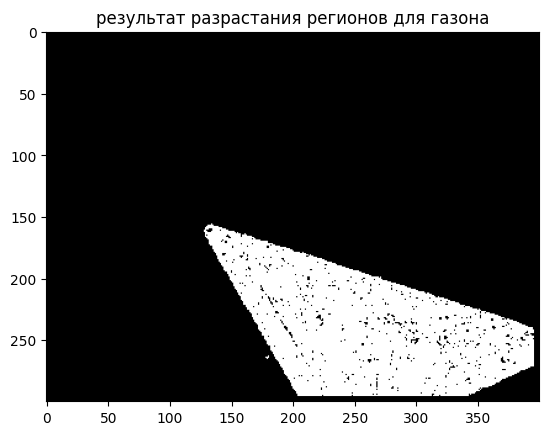

In [44]:
plt.imshow(res, cmap="gray")
plt.title("результат разрастания регионов для газона")
plt.show()

2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [45]:
def homo_median(img, mask, point, T):
    masked_region = img[mask > 0]
    if len(masked_region) == 0:
        return False
    median_val = np.median(masked_region)
    
    if abs(median_val - img[point]) <= T:
        return True
    
    return False

In [46]:
mask_average = region_growing(image_gray, seed_point, homo_average, 4, 25)
mask_median = region_growing(image_gray, seed_point, homo_median, 4, 25)

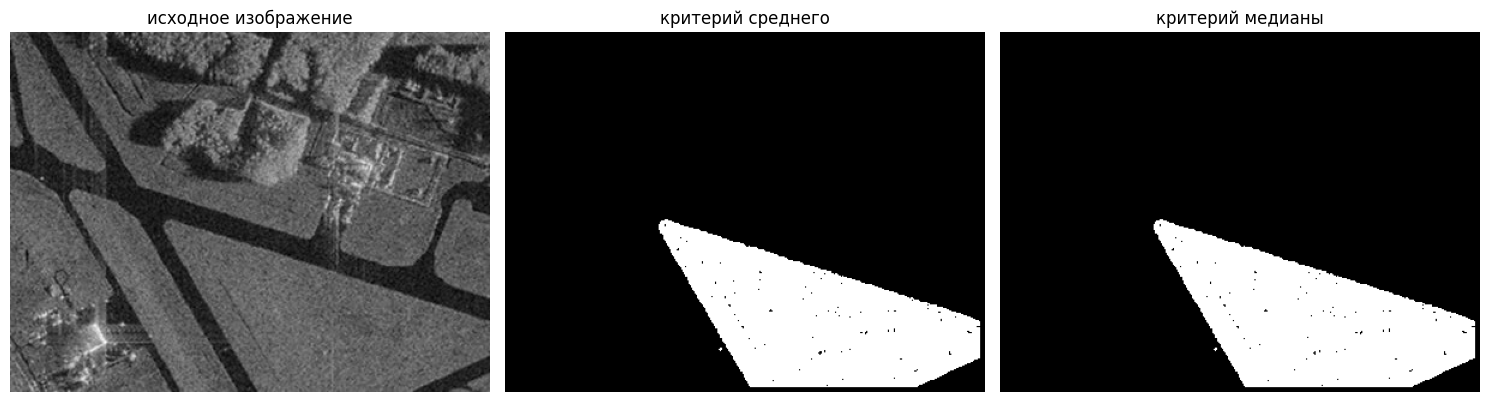

площадь (среднее): 20771
площадь (медиана): 20775


In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_gray, cmap='gray')
axes[0].set_title('исходное изображение')
axes[0].axis('off')

axes[1].imshow(mask_average, cmap='gray')
axes[1].set_title('критерий среднего')
axes[1].axis('off')

axes[2].imshow(mask_median, cmap='gray')
axes[2].set_title('критерий медианы')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"площадь (среднее): {np.count_nonzero(mask_average)}")
print(f"площадь (медиана): {np.count_nonzero(mask_median)}")

3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [93]:
image = cv2.imread('palm_1.JPG')
image_gray = cv2.imread('palm_1.JPG', cv2.IMREAD_GRAYSCALE)


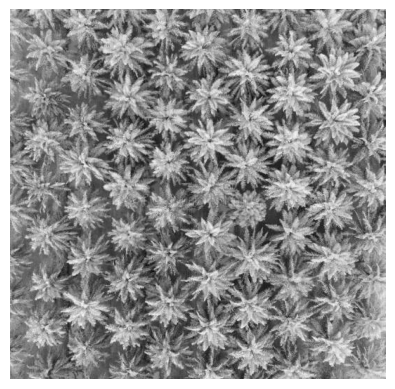

In [94]:
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

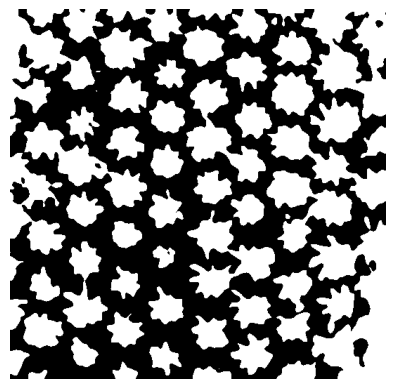

In [95]:
blurr = cv2.GaussianBlur(image_gray, (21, 21), 0)
ret, thresh = cv2.threshold(blurr,0,255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.show()

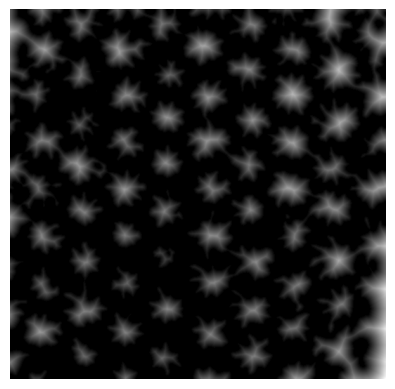

In [96]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap='gray')
plt.axis('off')
plt.show()

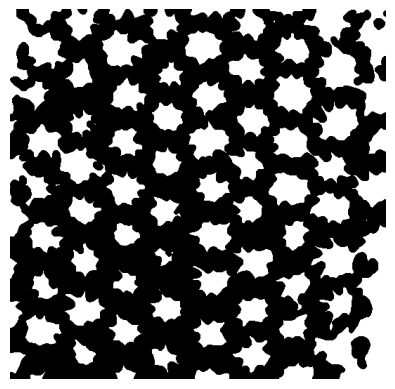

In [97]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.show()

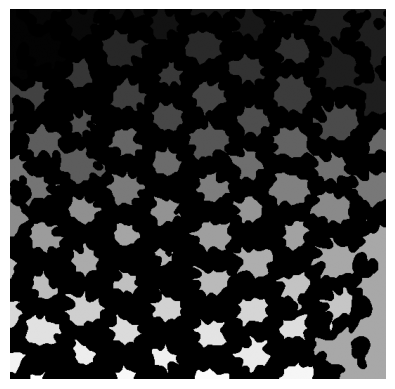

In [98]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show()

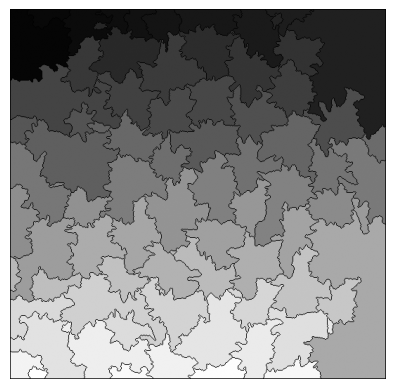

In [99]:
markers = cv2.watershed(image, markers)
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show()

In [100]:
result = len(np.unique(markers)) - 1
print(f'Количество пальм: {result}')

Количество пальм: 84
